# DETECCIÓN DE CELULAS BLANCAS EN MUESTRAS DE SANGRE



*   Samuel Lopera Torres
*   Angel Eugenio Pino Mazo
*   Santiago Arango Villa
*   Ivan Santiago Rojas Martínez
*   Jhonantan David Asprilla


---


UNIVERSIDAD NACIONAL DE COLOMBIA SEDE MEDELLIN

FACULTAD DE MINAS

SEMESTRE 2021-2



**Objetivo del Proyecto**

Con este proyecto, el equipo busca lograr identificar distintos tipos de células blancas en una muestra de sangre; el fin de este objetivo sería lograr un detector eficiente para detectar distintos tipos de células utilizando la herramienta de Python, y las librerías adicionales de Opencv, Matplotlib y Scikit.

**DATASET**

el dataset fue extraído de https://www.kaggle.com/paultimothymooney/blood-cells; se le agradece al usuario paultimothymooney por permitir el uso público de estos datos


In [ ]:
#NO MOVER, INSTALA DEPENDENCIAS Y VERSIONES NECESARIAS
!sudo pip install imgaug==0.2.6
!sudo pip install opencv-python==3.4.17.61

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 5.5 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=0a7ee9b98431a99637e8f5e22aa0baab3a5b6f4147748a806b25037e3ca60724
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58.0 MB 100 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


## Importamos librerías y definimos la ruta de acceso de las imágenes

***IMPORTANTE: Correr la siguiente celda antes de correr el resto del notebook, esta permite anexar la carpeta de Google Drive al resto del notebook para su uso, en caso de no ser utilizada, todas las funciones que llaman a un archivo presentara un error "No such file or directory"***

In [ ]:
#import images data from google drive 
from google.colab import drive
drive.mount('/content/drive')

from PIL import Image
import cv2
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
from skimage import morphology as morph
from skimage.measure import label, regionprops
import pandas as pd


warnings.filterwarnings('ignore')

#Definir funciones que agilizan la lectura de imágenes
def img_read(filename, mode = 'color'):
    if(mode == 'color'):   
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None

Mounted at /content/drive


#ANALISIS ESPACIOS DE COLOR

En esta sección se hace el análisis de los espacios de color a usar para poder realizar una segmentación efectiva; el análisis se inició utilizando una imagen del dataset en escala de grises, se puede observar que la célula objetivo tiene un color más oscuro que el resto de la imagen, pero algunas células rojas (Eritrocitos), también poseen sectores de este color, pudiendo afectar cualquier segmentación realizada.


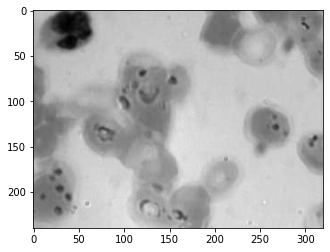

In [ ]:
img = cv2.imread("/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset2-master/dataset2-master/images/TEST_SIMPLE/EOSINOPHIL/_0_5239.jpeg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

En esta celda se hace el análisis con todos los colores del espacio RGB, dando como resultado la imagen que se puede observar en el dataset; no obstante, el espacio de color completo no nos permitiría realizar una segmentación satisfactoria, pues el mejor descriptor que tienen las células blancas (en esta imagen en específico Eosinófilos) es el color ligeramente azul que presentan en las imágenes tomadas con microscopio

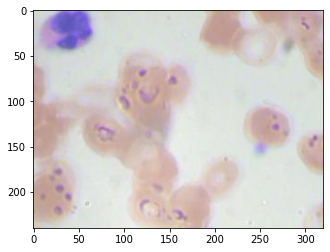

In [ ]:
img = cv2.imread("/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset2-master/dataset2-master/images/TEST_SIMPLE/EOSINOPHIL/_0_5239.jpeg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.imshow(img)

Tomando en cuenta lo anterior se realiza un análisis individual por cada uno de los canales RGB, donde se puede observar dos resultados interesantes
1. tanto el canal rojo como el canal azul presentan una separación considerable en las células blancas.   
2. no se separa completamente la célula blanca, y al igual que en el espacio de color GRAY, se observa que también quedan resaltados sectores pequeños dentro de las células rojas

por ende, se va a continuar el análisis en otros espacios de color, siendo estos CMY, YIQ, YUV, HSL y LAB




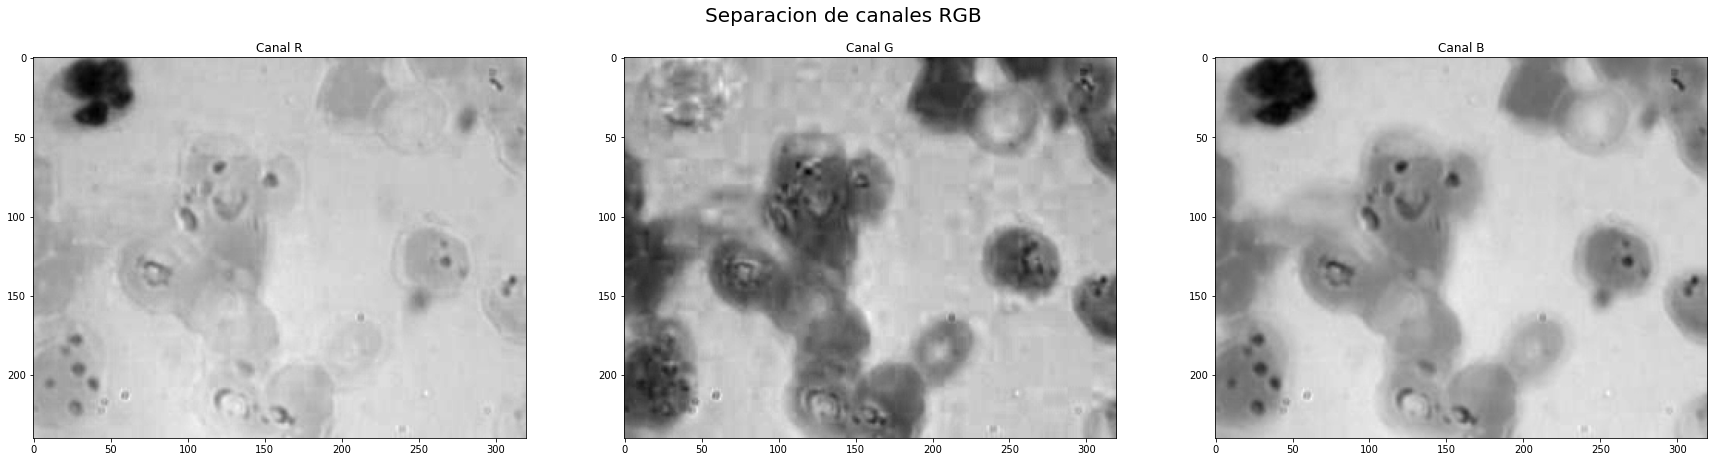

In [ ]:
#La intencion es revelar distintos niveles de contraste.

img_r = img[:,:,0]
img_b = img[:,:,1]
img_g = img[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30, 7))
#Se ponen títulos y se muestran las imágenes
fig.suptitle('Separacion de canales RGB', fontsize=20)
ax1.set_title('Canal R')
ax1.imshow(img_r, cmap='gray', aspect='auto')
ax2.set_title('Canal G')
ax2.imshow(img_g, cmap='gray', aspect='auto')
ax3.set_title('Canal B')
ax3.imshow(img_b, cmap='gray', aspect='auto')


En el espacio CMY no se llega a ver una separación especialmente satisfactoria, se nota que en los canales C(Cian) y M(Magenta) se resalta bastante la célula objetivo, pero, no se llega a dar una separación demasiado considerable del resto de la imagen. Además, se siguen observando partes resaltadas dentro de las células rojas.


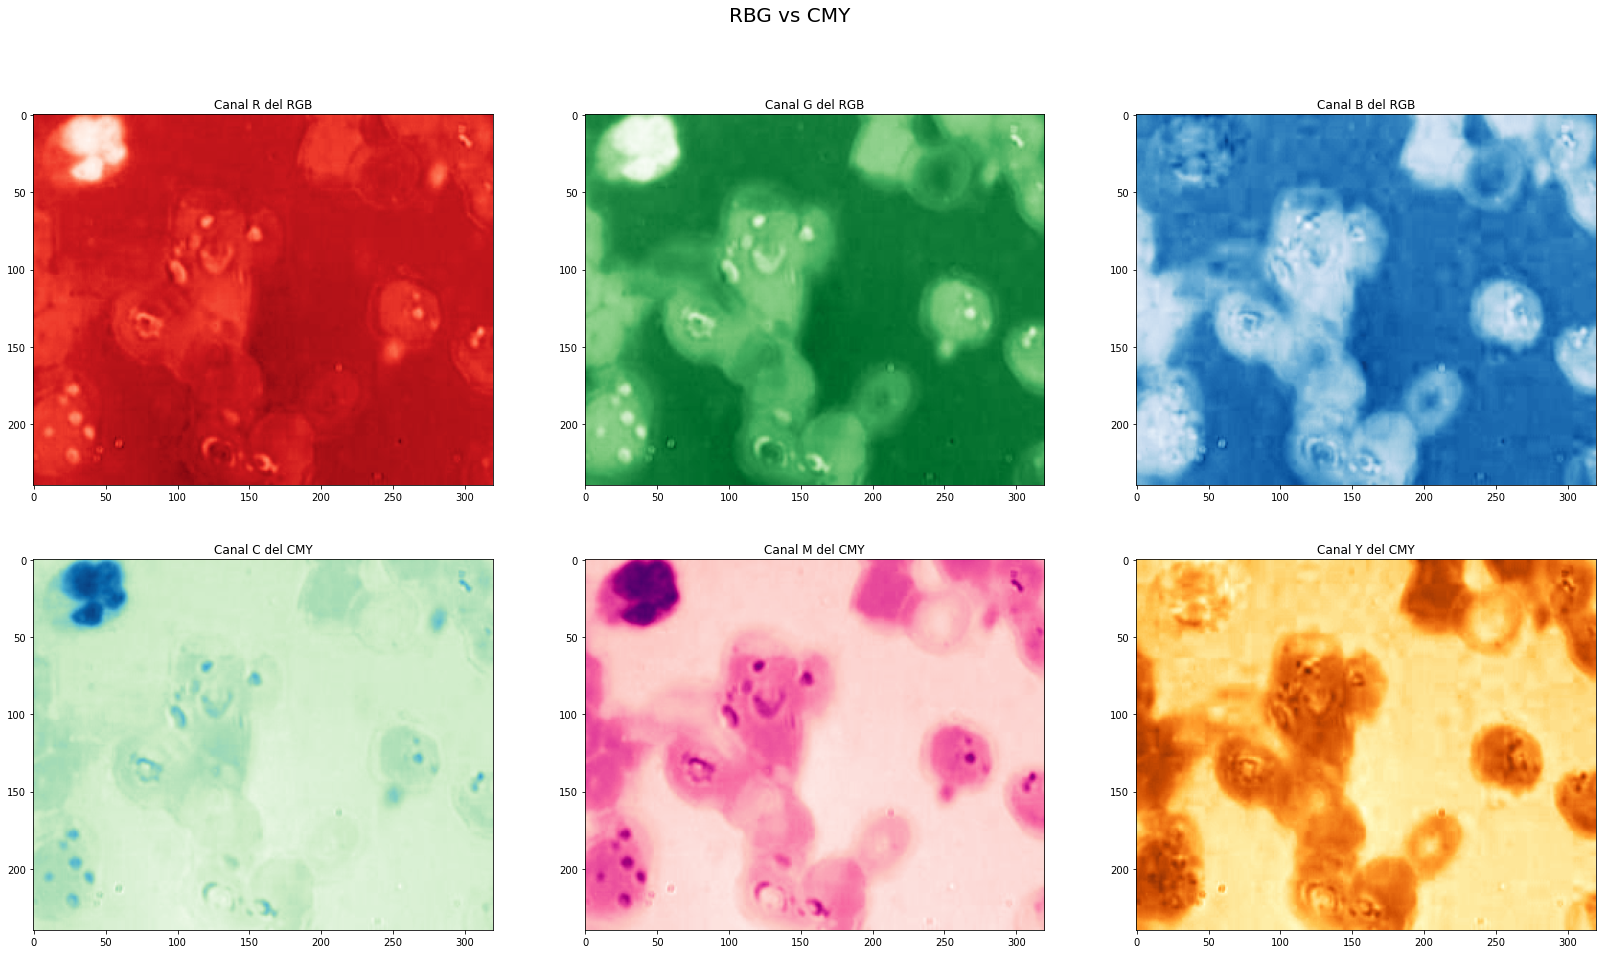

In [ ]:
#Modelo CMY

img_R = img[:,:,0]
img_G = img[:,:,1]
img_B = img[:,:,2]
#Se obtiene cada canal del espacio CMY con una transformación lineal
#a los canales R, G y B
img_C = 255 - img[:,:,0]
img_M = 255 - img[:,:,1]
img_Y = 255 - img[:,:,2]

#Se crea un subplot de 2x3, para mostrar las 6 imágenes y compararlas.
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(28, 15))
fig.suptitle('RBG vs CMY', fontsize=20)
ax1.set_title('Canal R del RGB')
ax1.imshow(img_R, cmap='Reds', aspect='auto')
ax2.set_title('Canal G del RGB')
ax2.imshow(img_G, cmap='Greens', aspect='auto')
ax3.set_title('Canal B del RGB')
ax3.imshow(img_B, cmap='Blues', aspect='auto')
ax4.set_title('Canal C del CMY')
ax4.imshow(img_C, cmap='GnBu', aspect='auto')
ax5.set_title('Canal M del CMY')
ax5.imshow(img_M, cmap='RdPu', aspect='auto')
ax6.set_title('Canal Y del CMY')
ax6.imshow(img_Y, cmap='YlOrBr', aspect='auto')

En el modelo YUV, se puede observar una separación similar a la observada en el canal GRAY, pero con problemas similares; a esto se le suma que los canales U y V están demasiado borrosos como para presentar algo de información sustancial, siempre se podrían aplicar filtros para reducir este ruido, pero deja de ser eficiente a la hora de segmentar, pudiendo consumir más recursos para este proceso.

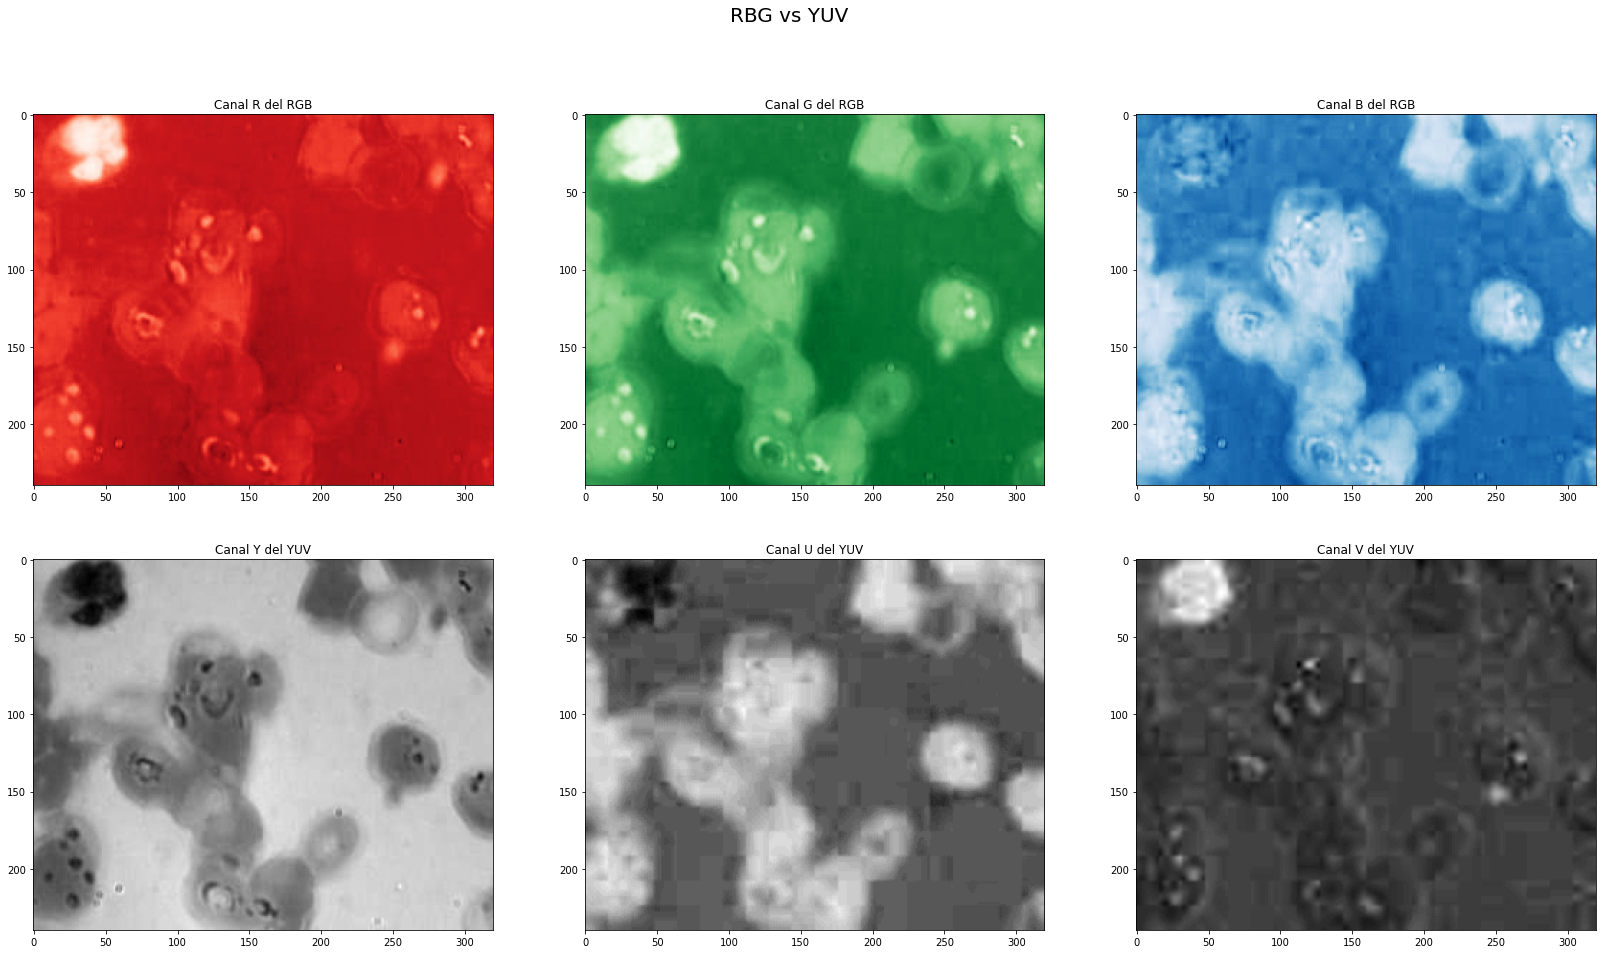

In [ ]:
#Modelo YUV

img_R = img[:,:,0]
img_G = img[:,:,1]
img_B = img[:,:,2]
#Separar el espacio de color YUV en sus canales individuales
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

img_Y = img_yuv[:,:,0]
img_U =  img_yuv[:,:,1]
img_V = img_yuv[:,:,2]
#Mostrar y comparar imágenes
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(28, 15))
fig.suptitle('RBG vs YUV', fontsize=20)
ax1.set_title('Canal R del RGB')
ax1.imshow(img_R, cmap='Reds', aspect='auto')
ax2.set_title('Canal G del RGB')
ax2.imshow(img_G, cmap='Greens', aspect='auto')
ax3.set_title('Canal B del RGB')
ax3.imshow(img_B, cmap='Blues', aspect='auto')
ax4.set_title('Canal Y del YUV')
ax4.imshow(img_Y, cmap='gray', aspect='auto')
ax5.set_title('Canal U del YUV')
ax5.imshow(img_U, cmap='gray', aspect='auto')
ax6.set_title('Canal V del YUV')
ax6.imshow(img_V, cmap='gray', aspect='auto')

En el espacio HSV se ve de las mejores opciones para separar la célula objetivo; siendo esta el canal H(Hue), donde se separa por el matiz general de un sector y no por los valores de un color especifico, separando con más efectividad la célula blanca; por otro lado los canales S(Saturation) y V (Value) no son precisamente óptimos, pues no dan información sobre el color como tal, sino de la saturación e iluminación de la imagen

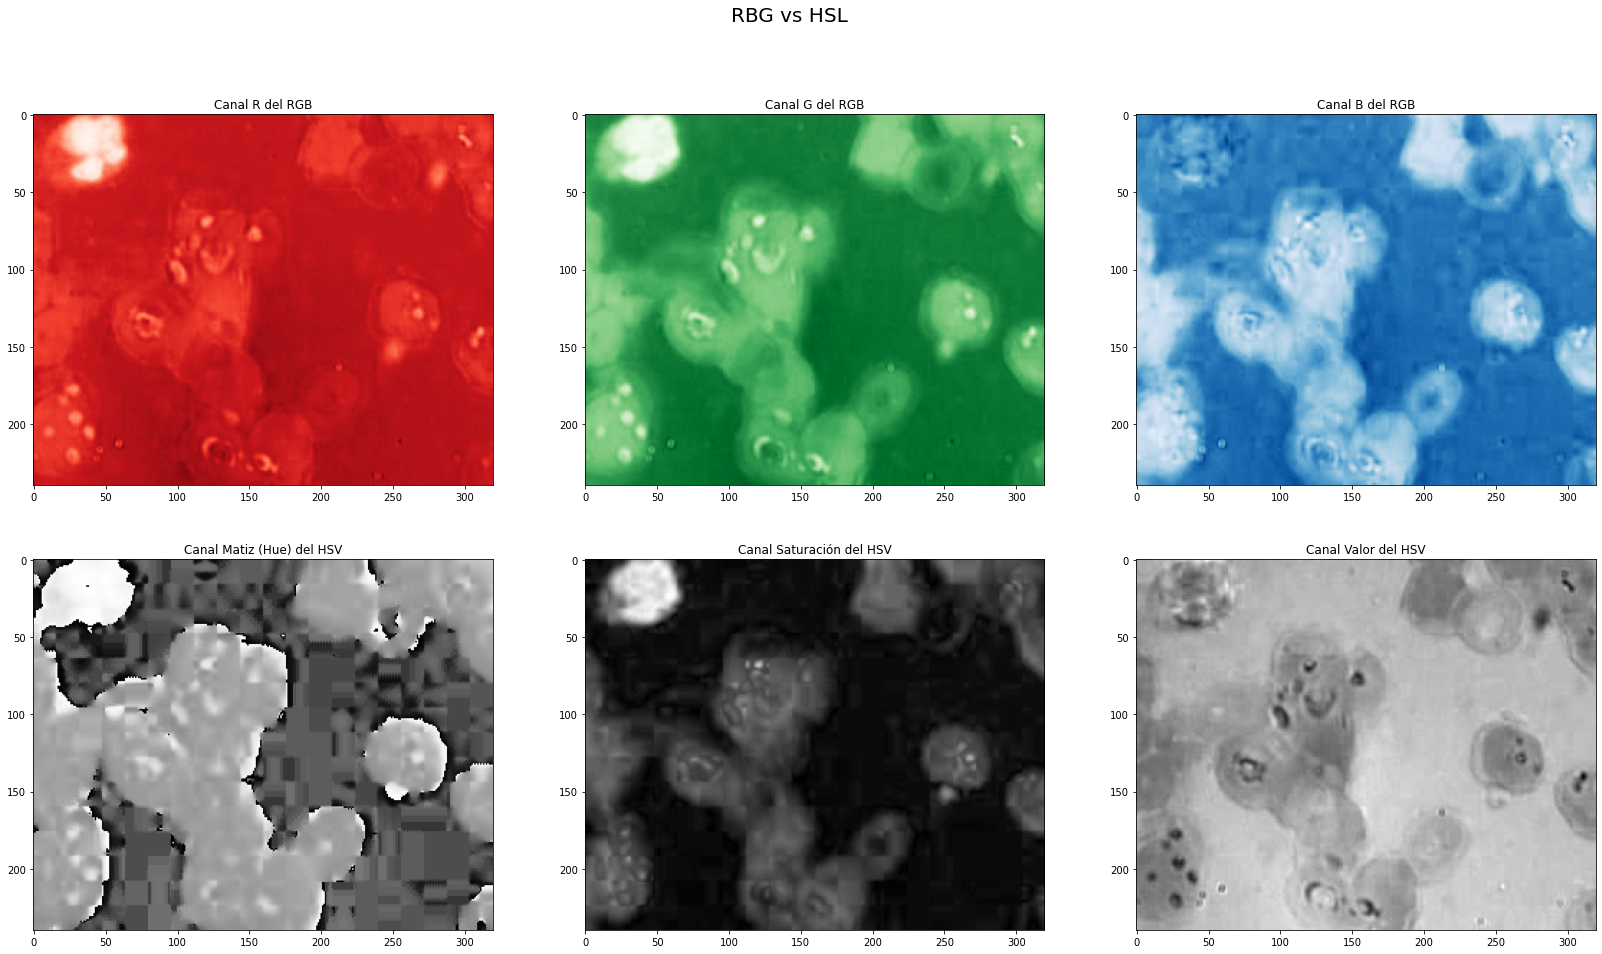

In [ ]:
#Modelo HSV

img_R = img[:,:,0]
img_G = img[:,:,1]
img_B = img[:,:,2]
#Conversiónomática con la función cv2.cvtColor al canal HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

img_H = img_hsv[:,:,0]
img_S =  img_hsv[:,:,1]
img_V = img_hsv[:,:,2]
#Mostrar y comparar imágenes
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(28, 15))
fig.suptitle('RBG vs HSL', fontsize=20)
ax1.set_title('Canal R del RGB')
ax1.imshow(img_R, cmap='Reds', aspect='auto')
ax2.set_title('Canal G del RGB')
ax2.imshow(img_G, cmap='Greens', aspect='auto')
ax3.set_title('Canal B del RGB')
ax3.imshow(img_B, cmap='Blues', aspect='auto')
ax4.set_title('Canal Matiz (Hue) del HSV')
ax4.imshow(img_H, cmap='gray', aspect='auto')
ax5.set_title('Canal Saturación del HSV')
ax5.imshow(img_S, cmap='gray', aspect='auto')
ax6.set_title('Canal Valor del HSV')
ax6.imshow(img_V, cmap='gray', aspect='auto')

Al igual que el espacio HSV, el espacio LAB puede ser bastante útil para nuestro proyecto, pues los canales correspondientes al color son invariantes frente a la luminosidad (esto descarta al canal L por defecto); considerando que es el canal A el que contiene la cantidad de azul, es el más efectivo; no obstante, el canal A es algo borroso y también posee puntos que quedan resaltados sin pertenecer al objetivo. el inverso del canal B también podría ser útil, pues este detecta parcialmente la célula objetivo, pero este también presenta el mismo problema que el canal A en mayor medida.

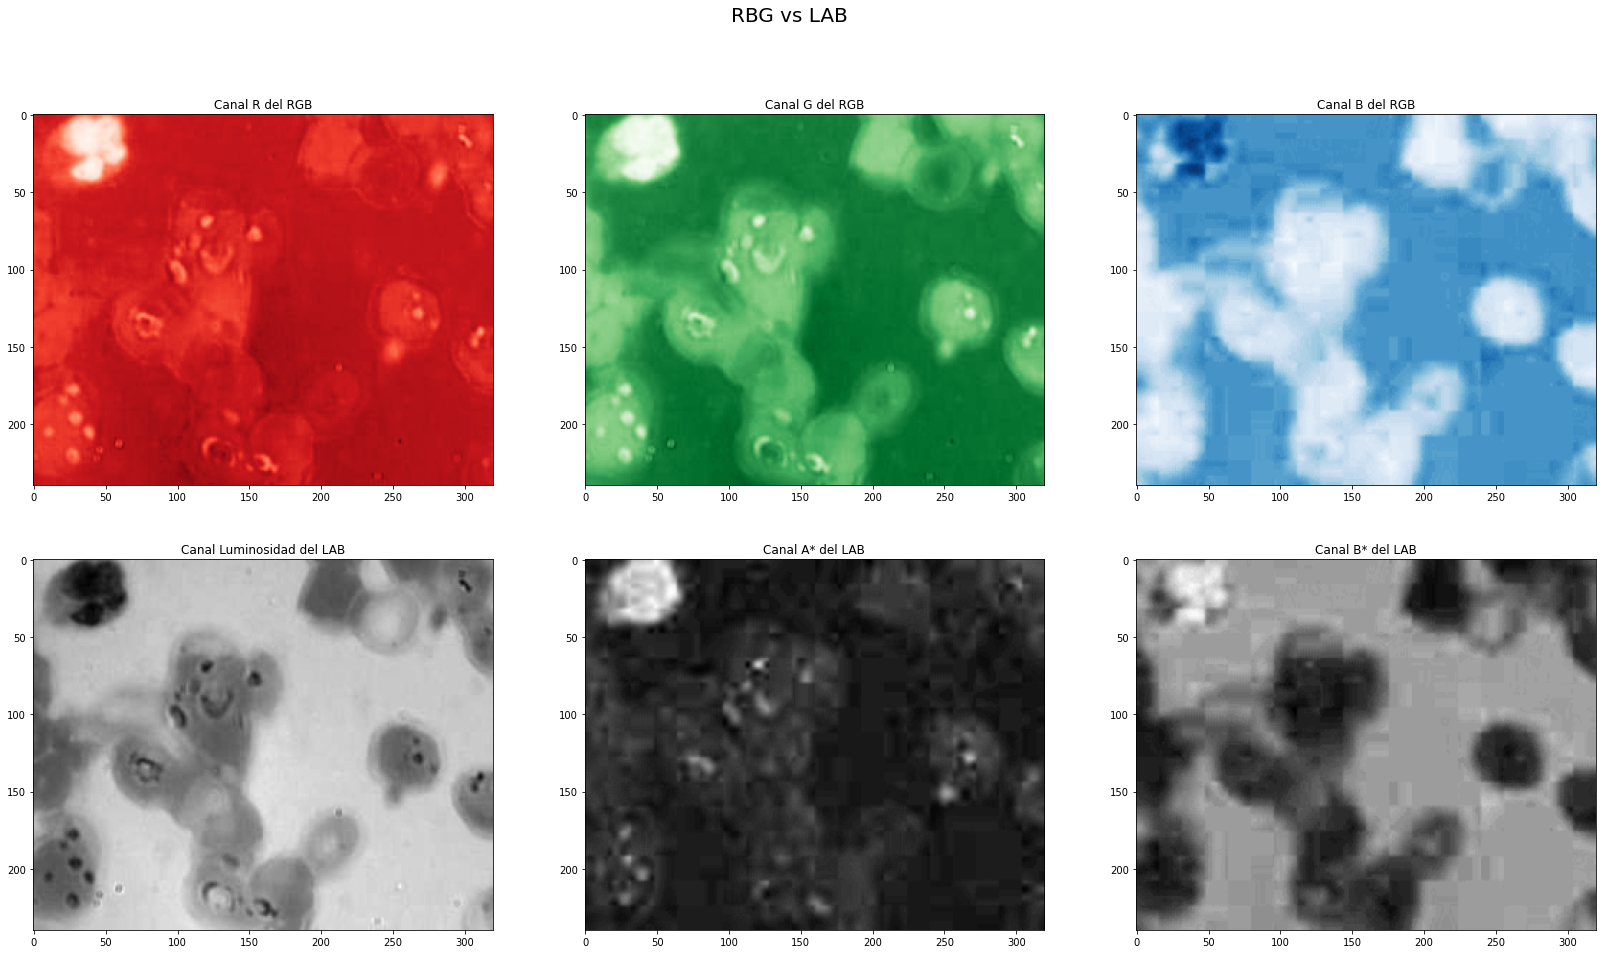

In [ ]:
#Modelo LAB

img_R = img[:,:,0]
img_G = img[:,:,1]
img_B = img[:,:,2]
#Lectura de cada canal correspondiente al espacio LAB
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

img_L = img_lab[:,:,0]
img_A =  img_lab[:,:,1]
img_B = img_lab[:,:,2]
#Mostrar y comparar imágenes
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(28, 15))
fig.suptitle('RBG vs LAB', fontsize=20)
ax1.set_title('Canal R del RGB')
ax1.imshow(img_R, cmap='Reds', aspect='auto')
ax2.set_title('Canal G del RGB')
ax2.imshow(img_G, cmap='Greens', aspect='auto')
ax3.set_title('Canal B del RGB')
ax3.imshow(img_B, cmap='Blues', aspect='auto')
ax4.set_title('Canal Luminosidad del LAB')
ax4.imshow(img_L, cmap='gray', aspect='auto')
ax5.set_title('Canal A* del LAB')
ax5.imshow(img_A, cmap='gray', aspect='auto')
ax6.set_title('Canal B* del LAB')
ax6.imshow(img_B, cmap='gray', aspect='auto')

# PREPROCESAMIENTO Y SEGMENTACIÓN
Ya con esto se realiza el análisis de posibles operaciones de preprocesamiento a utilizar; en este caso el primer análisis es relacionado con el negativo de la imagen en GRAY, en cualquier caso, sigue poseyendo los mismos problemas que la imagen original en el espacio GRAY


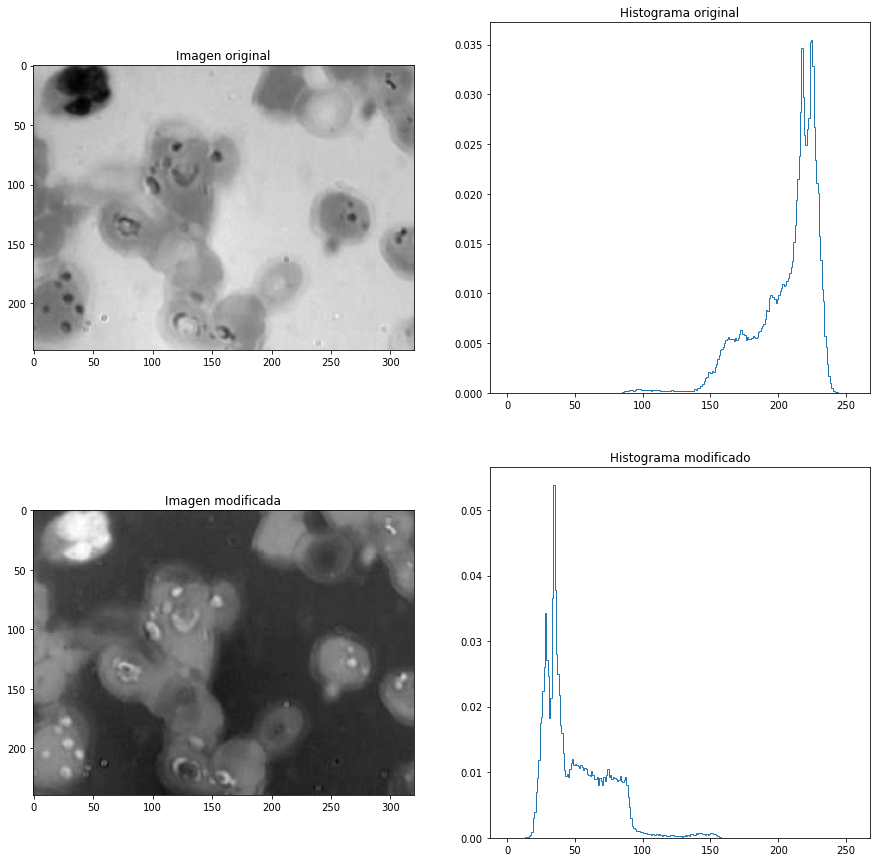

In [ ]:
#El negativo
img = cv2.imread("/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset2-master/dataset2-master/images/TEST_SIMPLE/EOSINOPHIL/_0_5239.jpeg", cv2.IMREAD_COLOR)
img_2 =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_subtract= np.zeros(img_2.shape, np.uint8)
#El negativo de la imagen corresponde a restar de la matriz cuyas componentes son 255,
#la matriz de la imagen que cargamos
img_subtract = cv2.subtract(255, img_2)

#Se realiza el arreglo de 2x2 para mostrar imagen e imagen modificada vs histogramas
fig, arreglo_plots = plt.subplots(2,2, figsize=(15, 15))

#Se le dan títulos a los cuadros, se imprimen las imágenes y sus histogramas
arreglo_plots[0,0].set_title('Imagen original')
arreglo_plots[0,0].imshow(img_2, cmap="gray")
arreglo_plots[0,1].set_title('Histograma original')
img_array = img.ravel()
_ = arreglo_plots[0,1].hist(img_array,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True)

arreglo_plots[1,0].set_title('Imagen modificada')
arreglo_plots[1,0].imshow(img_subtract, cmap="gray")
arreglo_plots[1,1].set_title('Histograma modificado')
img_array = img_subtract.ravel()
_ = arreglo_plots[1,1].hist(img_array,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True)

En esta celda se realizaron experimentos con el algoritmo Canny que proporciona la librería de Opencv, para determinar si la descripción con respecto a la forma era viable, al final tras hacer experimentos con distintos valores para los diferenciales en x y en y, quedo determinado que no era lo suficientemente conclusivo; aquí adelante se presentan algunos de estos resultados.



*   Dx= 10 y Dy = 10, se detectan demasiados contornos, incluyendo algunos del interior de las células o parte de la compresión JPG,
*   Dx= 20 y Dy =20, dejan de detectarse partes de la compresión del archivo, pero sigue dejando demasiados contornos
*   Dx= 50 y Dy = 40, ya se distinguen mejor los contornos exteriores de las células
*   Dx= 100 y Dy= 90, se detectan pocos contornos, y aproximadamente queda únicamente la célula objetivo, pero, se detecta solo parte del borde interior, pudiendo llevar a una detección parcial del objeto.





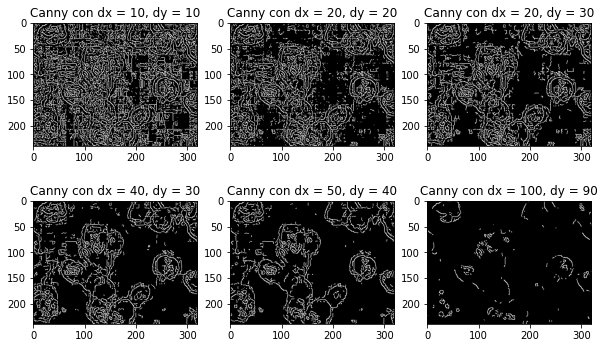

In [ ]:
edges1 = cv2.Canny(img,10,10)
edges2 = cv2.Canny(img,20,20)
edges3 = cv2.Canny(img,20,30)
edges4 = cv2.Canny(img,40,30)
edges5 = cv2.Canny(img,50,40)
edges6 = cv2.Canny(img,100,90)

fig, arreglo_plots = plt.subplots(2,3,figsize = (10,6))
arreglo_plots[0,0].set_title("Canny con dx = 10, dy = 10")
arreglo_plots[0,0].imshow(edges1, cmap = 'gray')
arreglo_plots[0,1].set_title("Canny con dx = 20, dy = 20")
arreglo_plots[0,1].imshow(edges2, cmap = 'gray')
arreglo_plots[0,2].set_title("Canny con dx = 20, dy = 30")
arreglo_plots[0,2].imshow(edges3, cmap = 'gray')
arreglo_plots[1,0].set_title("Canny con dx = 40, dy = 30")
arreglo_plots[1,0].imshow(edges4, cmap = 'gray')
arreglo_plots[1,1].set_title("Canny con dx = 50, dy = 40")
arreglo_plots[1,1].imshow(edges5, cmap = 'gray')
arreglo_plots[1,2].set_title("Canny con dx = 100, dy = 90")
arreglo_plots[1,2].imshow(edges6, cmap = 'gray')

En esta celda se experimentó con el umbral binario sobre el canal A del espacio lab, se utilizó además el umbral de Otsu; este experimento nos llevó a la conclusión de que el canal A no es óptimo, pues detecta también las demás células.

cabe recalcar que, el desarrollo de este proyecto este proceso fue uno que conllevo bastantes problemas relacionados con la librería Opencv, pues no estaba llevando a cabo el umbral sobre la imagen, fue el umbral de Otsu la solución parcial a este problema después de mucha búsqueda en páginas como Stackoverflow


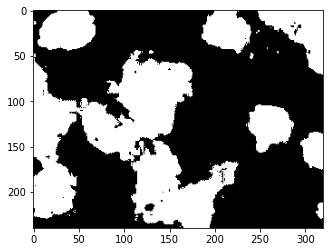

In [ ]:
img_A = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,1]
ret, thresh_img = cv2.threshold(img_A, 0, 100, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresh_img, cmap = "gray")

después de analizar y sacar varias conclusiones nos propusimos a crear una máscara de la célula variando su umbral, en este caso utilizamos el umbral con el espacio HSV, se utilizó la operación inRange para detectar las dos variaciones de azul que posee la célula, y luego se realizó la operación lógica para presentar el resultado

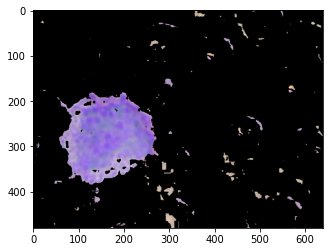

In [ ]:
img = cv2.cvtColor(cv2.imread("/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00008.jpg"), cv2.COLOR_BGR2RGB)
img_HSV = cv2.cvtColor(cv2.imread("/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00008.jpg"), cv2.COLOR_BGR2HSV)
lower_blue = np.array([10,40,188])
upper_blue = np.array([159,171,255])
mask = cv2.inRange(img_HSV, lower_blue, upper_blue)
res = cv2.bitwise_and(img,img, mask= mask)

plt.imshow(res)

En esta celda se repitió el proceso con otra imagen para corroborar resultados, como se puede ver, son bastante satisfactorios, pero falta realizar operaciones morfológicas para acabar de generar una máscara satisfactoria.

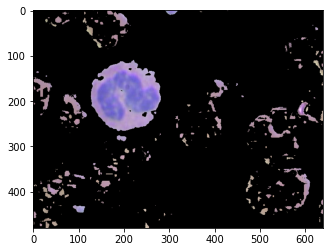

In [ ]:
img = cv2.cvtColor(cv2.imread("/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00019.jpg"), cv2.COLOR_BGR2RGB)
img_HSV = cv2.cvtColor(cv2.imread("/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00019.jpg"), cv2.COLOR_BGR2HSV)
lower_blue = np.array([10,40,100])
upper_blue = np.array([170,170,255])
mask = cv2.inRange(img_HSV, lower_blue, upper_blue)
res = cv2.bitwise_and(img,img, mask= mask)

plt.imshow(res)

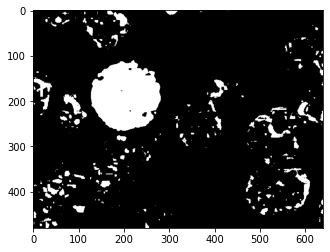

In [ ]:
umbral=1
mascara = np.uint8((res>umbral)*255)

plt.imshow(mascara, cmap='gray')

se inician a hacer llenados para acabar de ajustar la máscara a la célula objetivo


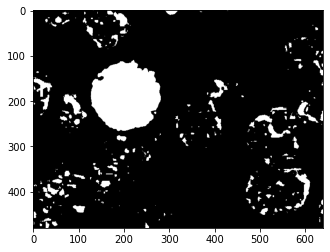

In [ ]:
umbral = mascara[:,:,0]
umbral1=umbral.copy()
h, w = umbral.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(umbral1,mask ,(0,0), 255);
iv_umbral1=cv2.bitwise_not(umbral1)
filled = umbral|iv_umbral1
plt.imshow(filled,cmap='gray')

ya con todo lo visto anteriormente se llega a una máscara satisfactoria que separa la célula objetivo del resto de la imagen

290
17842


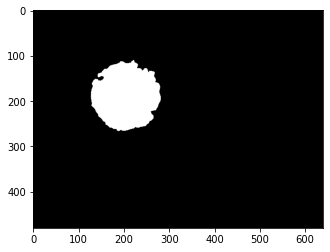

In [ ]:
from matplotlib.image import imread
label_img = label(filled)
props = regionprops(label_img )
num_reg = len(props)
num_cel = num_reg
print(num_cel)
for i in range(num_reg):
  if props[i].area>5000:
    A=label_img==i+1
    print(props[i].area)
    img_copy = A.astype(np.float32)/255
    plt.imshow(A,cmap='gray')

se realiza la operación de multiplicación para observar el resultado, y como se puede ver, queda completamente segmentada la célula objetivo

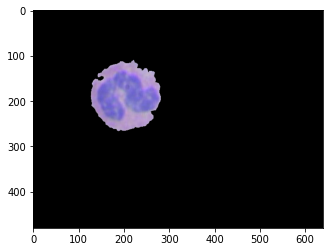

In [ ]:
MASC = cv2.cvtColor(np.float32(A), cv2.COLOR_GRAY2BGR)
imagen = MASC*img
operacion=imagen/255
plt.imshow(operacion)

# Clasificación de glóbulos blancos con un modelo entrenado


En esta sección se observa el modelo que creamos para clasificar de manera automática las células objetivo; al ser cuatro tipos de células (realmente 5, pero el dataset utilizado no tiene suficientes muestras del 5to tipo para realizar un modelo realmente efectivo), Eosinófilos, Linfocitos, Monocitos y Neutrófilos, cada una de las cuales se le asigno un modelo y tienen un archivo .xml que funciona como descriptor; como clasificador estamos usando el método de Cascadas de Haar, el cual, tras investigar, concluimos era el mejor ajustado a nuestras necesidades, en la celda que sigue queda definida una función que permite facilitar el proceso en vez de utilizar la funcion a mano; recibe el tipo de célula como primer argumento posicional y la imagen como Strings, además, está el ejemplo del clasificador para los eosinófilos; cualquiera que este leyendo este archivo, se puede experimentar con cada uno de los formatos de archivo

**/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00###.jpg'**

donde los ### son el numero de la muestra; a continuación también pueden observar impreso por consola los índices de cada uno de los tipos de célula; en caso de que el índice tenga menos de 3 dígitos, añada ceros a la izquierda; ej: 34 = 034, 2 = 002

el método también está planteado de tal manera que se puede llamar en la función integrada de Python "help()" para ver la documentación.


In [ ]:
import pandas as pd

labels = pd.read_csv("/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/labels.csv")
labels = labels.dropna(subset = ["Category"])

arrayNeutrophil = labels[labels['Category'] == 'NEUTROPHIL'].index.to_numpy()
arrayMonocyte = labels[labels['Category'] == 'MONOCYTE'].index.to_numpy()
arraysLymphocyte = labels[labels['Category'] == 'LYMPHOCYTE'].index.to_numpy()
arraysEosinophil = labels[labels['Category'] == 'EOSINOPHIL'].index.to_numpy()

print("NEUTROFILOS",arrayNeutrophil)
print("MONOCITOS",arrayMonocyte)
print("LINFOCITOS",arraysLymphocyte)
print("EOSINOFILOS",arraysEosinophil)

NEUTROFILOS [  0   1   2   3   4   5   6   7  11  12  13  14  16  18  19  22  24  29
  30  32  33  35  39  46  50  52  53  63  66  67  71  72  73  74  77  78
  79  81  82  86  87  91  92  98 106 112 113 115 124 125 126 130 136 142
 145 150 156 159 161 163 164 166 167 168 169 170 172 174 175 178 179 182
 189 190 192 197 198 199 201 203 205 207 209 210 212 214 215 216 218 221
 222 223 227 230 231 234 235 237 239 243 244 245 246 247 248 250 252 256
 257 260 263 266 267 268 272 273 276 279 280 282 285 287 288 293 294 295
 296 297 298 300 301 302 303 304 307 308 310 311 314 315 317 320 322 324
 325 326 327 329 330 331 332 333 334 336 337 338 339 340 341 343 346 348
 349 350 351 354 355 357 360 361 362 364 365 366 367 368 369 370 371 372
 375 377 378 379 381 382 384 385 386 388 389 390 391 392 393 395 396 397
 398 400 402 403 404 405 407 408 409]
MONOCITOS [ 15  40  83 104 110 116 127 196 225 232 255 262 278 281 291 309 312 318
 323 335 342]
LINFOCITOS [ 20  21  37  38  47  54  55  76  89  9

Para poder usar las imagenes que contengan exclusivamente a los globulos blancos de cada muestra, para entrenar el modelo, necesitamos que estas tengan el mismo tamaño. Para esto, usamos un codigo simple y facil de entender que nos permite encontrar el promedio de las dimensiones en todo el dataset, adenas de redimensionarlas a dichas dimensiones:

In [ ]:
def size_images(original_source):
  #param original_source: ruta de la carpeta que contiene las imagenes
  #return: regresa como resultado el promedio de las dimensiones de las imagenes encontradas
  x = []
  y = []
  avereage = [0,0]
  images = os.listdir(original_source)
  for image in images:
      source = original_source + image
      img = Image.open(source) 
      width, height = img.size
      x.append(width)
      y.append(height)
  for width in x:
      avereage[0] += width / len(x)
  for height in y:
      avereage[1] += height / len(y)
  avereage[0] = int(avereage[0])
  avereage[1] = int(avereage[1])
  return avereage

def resize_images(original_source, avereage, final_source):
  #param original_source: ruta de la carpeta que contiene las imagenes a redimensionar
  #param avereage: promedio de las dimensiones de las imagenes
  #param final_source: ruta de la carpeta donde se guardaran las imagenes

  images = os.listdir(original_source)
  for image in images:
      img = Image.open(original_source + image)
      img = img.resize((avereage[0], avereage[1]))
      img.save(final_source + image)

Una vez tenemos nuestras imagenes para entrenar los clasificadores, usaremos el programa HaarCascadeGui, el cual usa la version 3.4.11 de opencv para hacer el entrenamiento. Una vez hayamos entrenado los classifiers, podemos entonces usarlos para poder clasificar los globulos blancos

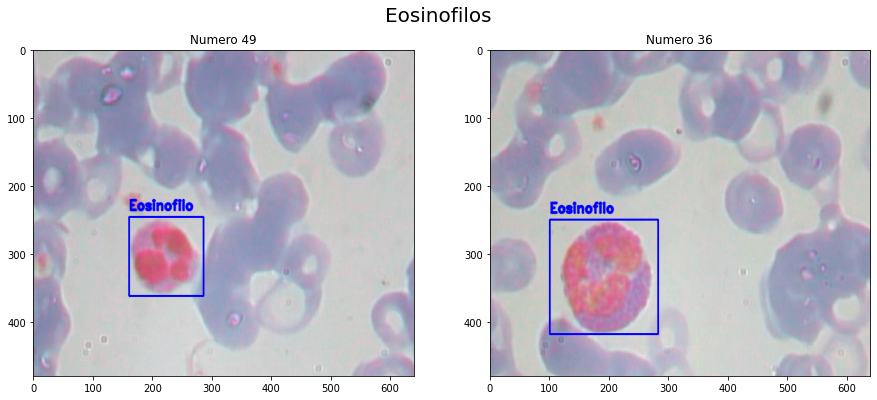

In [ ]:
def classifier(cell_type, img_source):
  """Este metodo usara el modelo entrenado necesario para detectar cierto tipo de globulo blanco
      param cell_type: tipo de celula a detectar, se escribe el nombre en español y con la primera letra mayuscula, ejemplo: "Eosinofilo"
      param img_source: fuente absoluta de la imagen donde se aplicara la deteccion"""
  if(cell_type == 'Eosinofilo'):
    cell_class =  cv2.CascadeClassifier('/content/drive/Shareddrives/Deteccion de bacterias/Detectores/eosinofilos/cascade.xml')
  elif(cell_type == 'Linfocito'):
    cell_class =  cv2.CascadeClassifier('/content/drive/Shareddrives/Deteccion de bacterias/Detectores/linfocitos/cascade.xml')
  elif(cell_type == 'Monocito'):
    cell_class =  cv2.CascadeClassifier('/content/drive/Shareddrives/Deteccion de bacterias/Detectores/monocitos/cascade.xml')
  elif(cell_type == 'Neutrofilo'):
    cell_class =  cv2.CascadeClassifier('/content/drive/Shareddrives/Deteccion de bacterias/Detectores/neutrofilos/cascade.xml')

  img = cv2.imread(img_source)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #Todas las detecciones se guardaran en la variable 'cell', ademas de definir parametros necesarios como 'scaleFactor'
  cell = cell_class.detectMultiScale(gray,
  scaleFactor = 1.10,
  minNeighbors = 3,
  minSize=(22,20))
  #Desempaquetamos la informacion dentro de 'cell', para luego usarla para dibujar un rectangulo que rodee a el globulo blanco detectado
  for (x,y,w,h) in cell:
    cv2.rectangle(img, (x,y),(x+w,y+h),(0,0,255),2)
    cv2.putText(img,f'{cell_type}',(x,y-10),2,0.7,(0,0,255),2,cv2.LINE_AA)
  return img

#Detectaremos 2 eosinofilos de diferentes imagenes, para luego mostrar las imagenes resultantes 
eosinofilo1 = classifier('Eosinofilo', img_source='/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00049.jpg')
eosinofilo2 = classifier('Eosinofilo', img_source='/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00036.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Eosinofilos', fontsize=20)
ax1.set_title('Numero 49')
ax1.imshow(eosinofilo1, cmap='gray', aspect='auto')
ax2.set_title('Numero 36')
ax2.imshow(eosinofilo2, cmap='gray', aspect='auto')


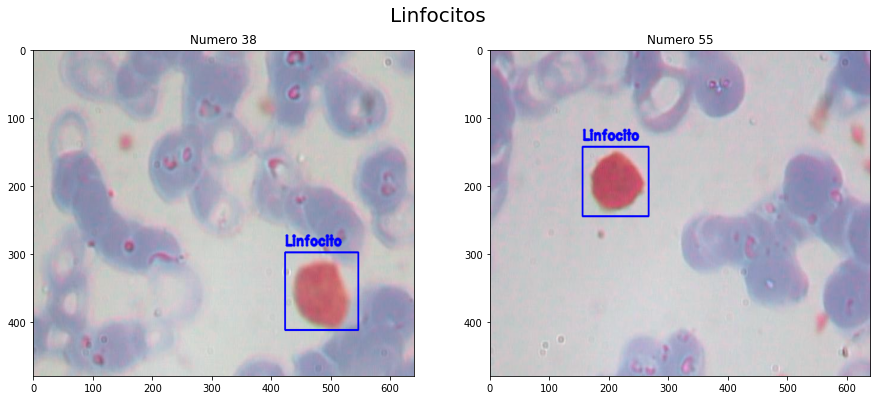

In [ ]:
Linfocito1 = classifier('Linfocito', img_source='/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00038.jpg')
Linfocito2 = classifier('Linfocito', img_source='/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00055.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Linfocitos', fontsize=20)
ax1.set_title('Numero 38')
ax1.imshow(Linfocito1, cmap='gray', aspect='auto')
ax2.set_title('Numero 55')
ax2.imshow(Linfocito2, cmap='gray', aspect='auto')

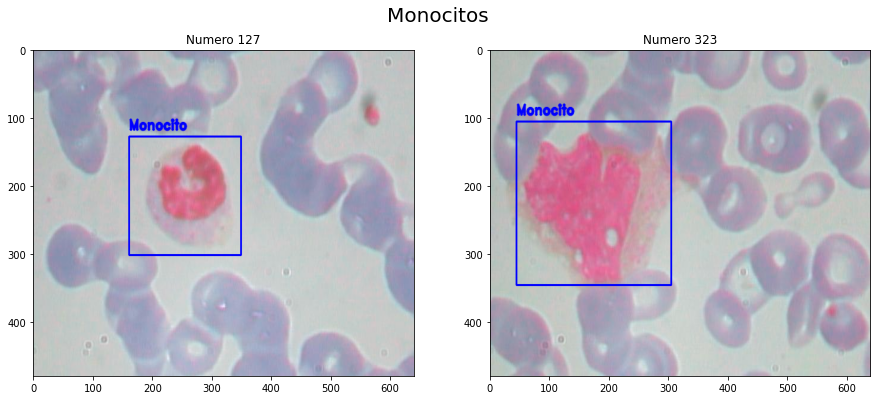

In [ ]:
Monocito1 = classifier('Monocito', img_source='/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00127.jpg')
Monocito2 = classifier('Monocito', img_source='/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00323.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Monocitos', fontsize=20)
ax1.set_title('Numero 127')
ax1.imshow(Monocito1, cmap='gray', aspect='auto')
ax2.set_title('Numero 323')
ax2.imshow(Monocito2, cmap='gray', aspect='auto')

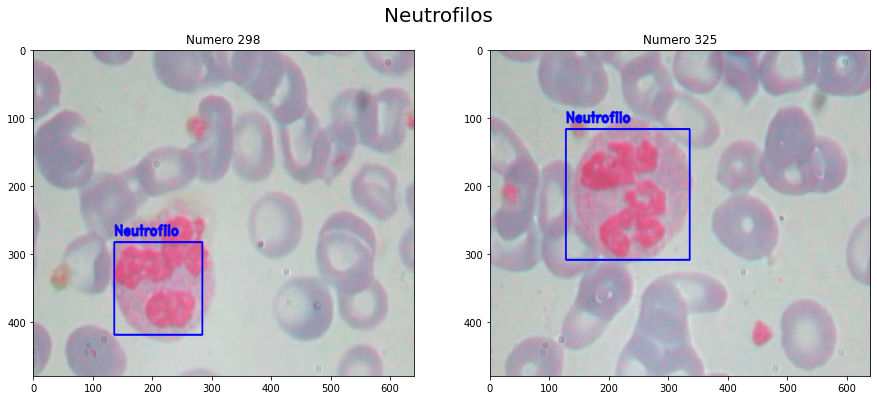

In [ ]:
Neutofilo1 = classifier('Neutrofilo', img_source='/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00298.jpg')
Neutofilo2 = classifier('Neutrofilo', img_source='/content/drive/Shareddrives/Deteccion de bacterias/Globulos/dataset-master/dataset-master/JPEGImages/BloodImage_00325.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Neutrofilos', fontsize=20)
ax1.set_title('Numero 298')
ax1.imshow(Neutofilo1, cmap='gray', aspect='auto')
ax2.set_title('Numero 325')
ax2.imshow(Neutofilo2, cmap='gray', aspect='auto')

 # Conclusión

para concluir este proyecto, cabe recalcar que estas nuevas tecnologías y la visión por computador podrían revolucionar varios campos de la sociedad actual; tomando este proyecto por ejemplo; conociendo como se ve una enfermedad al entrar al flujo sanguíneo, se podría identificar por medio de modelos de aprendizaje automático para detectarla con mayor rapidez y combatirla antes de que llegue a causar daños considerables.


# Bibliografia
*   https://omes-va.com/como-crear-tu-propio-detector-de-objetos-con-haar-cascade-python-y-opencv/
*   https://amin-ahmadi.com/cascade-trainer-gui/

